# **Training a Linear SVM Classifier on Intel Image Classification Dataset**

### **Initial Setup** ###

In [ ]:
!pip install torch
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### **External Libraries** ###

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset, Dataset
import pandas as pd
from torchvision import transforms
import numpy as np
import os
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

### **Extract HOG features from the Intel Image Classification dataset** ###

In [ ]:
def get_hog_data(images_path, width, height, orient=9, pixelsxcell=(12, 12), cellsxblock=(3, 3)):

  # Initialize arrays to save all HOG features and GT
  feature_size = int(np.trunc((height/pixelsxcell[0])-(cellsxblock[0]-1))*np.trunc((width/pixelsxcell[1])-(cellsxblock[1]-1))\
                  *(cellsxblock[0]*cellsxblock[1]*orient))
  # Define arrays to save all HOG features and GT
  X = np.empty([0,feature_size])
  Y = np.empty([0,1])

  # Traverse through the main directory
  for class_folder in os.listdir(images_path):
      class_path = os.path.join(images_path, class_folder)

      # Traverse through the subdirectories (each class)
      for image_file in os.listdir(class_path):
          img_path = os.path.join(class_path, image_file)
          img = cv2.imread(img_path, 0)  # Read image in grayscale

          if img is None:
              print(f"Failed to load image: {img_path}")
              continue

          img = cv2.resize(img, (width, height))  # Resize image
          Xp, hog_image = hog(img, orientations=orient, pixels_per_cell=pixelsxcell,
                              cells_per_block=cellsxblock, visualize=True)
          X = np.append(X, [Xp], axis=0)  # Append features

          # Assign class label based on the subfolder name
          class_label = class_folder  # The class folder name is the class label
          Y = np.append(Y, [[class_label]], axis=0)

  return X, Y.flatten()

In [ ]:
# Define paths for training and testing data
train_path = 'intel_image_classification/seg_train/seg_train/'
test_path = 'intel_image_classification/seg_test/seg_test/'

# Extract HOG features from the training set
X_train, Y_train = get_hog_data(train_path, width=64, height=64)  # Use your desired dimensions
print(f"Training Features shape: {X_train.shape}, Labels shape: {Y_train.shape}")

# Extract HOG features from the testing set
X_test, Y_test = get_hog_data(test_path, width=64, height=64)  # Use your desired dimensions
print(f"Testing Features shape: {X_test.shape}, Labels shape: {Y_test.shape}")


Training Features shape: (14034, 729), Labels shape: (14034,)
Testing Features shape: (3000, 729), Labels shape: (3000,)


In [ ]:
# Initialize an array for numeric labels
Y_train_numeric = np.empty((14034,))
Y_test_numeric = np.empty((3000,))

for i in range(14034):
  if(Y_train[i] == "buildings"):
    Y_train_numeric[i] = 0
  elif(Y_train[i] == "forest"):
    Y_train_numeric[i] = 1
  elif(Y_train[i] == "glacier"):
    Y_train_numeric[i] = 2
  elif(Y_train[i] == "mountain"):
    Y_train_numeric[i] = 3
  elif(Y_train[i] == "sea"):
    Y_train_numeric[i] = 4
  else:
    Y_train_numeric[i] = 5

for i in range(3000):
  if(Y_test[i] == "buildings"):
    Y_test_numeric[i] = 0
  elif(Y_test[i] == "forest"):
    Y_test_numeric[i] = 1
  elif(Y_test[i] == "glacier"):
    Y_test_numeric[i] = 2
  elif(Y_test[i] == "mountain"):
    Y_test_numeric[i] = 3
  elif(Y_test[i] == "sea"):
    Y_test_numeric[i] = 4
  else:
    Y_test_numeric[i] = 5


### **Define Confusion Matrix** ###

In [ ]:
def get_confusion_matrix(clf,X,Y,title):
    # Get predictions
    res = clf.predict(X)
    # Define Confusion Matrix
    cm = metrics.confusion_matrix(Y, res)
    # Plot confusion matrix
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label')
    plt.title("Confusion matrix "+title+" data", size = 15)

### **Defining Training for a Linear SVM Classifier** ###

In [ ]:
def SVM(Xtrain, Ytrain, Xval, Yval):
    print("--------Support Vector Machine--------\n")
    clf = SVC(random_state=0)
    clf.fit(Xtrain, Ytrain)
    print("Accuracy Train set:", clf.score(Xtrain, Ytrain) * 100)
    print("Accuracy Valid set:", clf.score(Xval, Yval) * 100)

    # Confusion matrix
    get_confusion_matrix(clf,Xval,Yval,"Validation")

    return clf

### **Split Train Dataset for Train and Val** ###

In [ ]:
# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train_numeric, test_size=0.2, random_state=42)

### **Training** ###

--------Support Vector Machine--------

Accuracy Train set: 85.04498084973724
Accuracy Valid set: 72.96045600285001


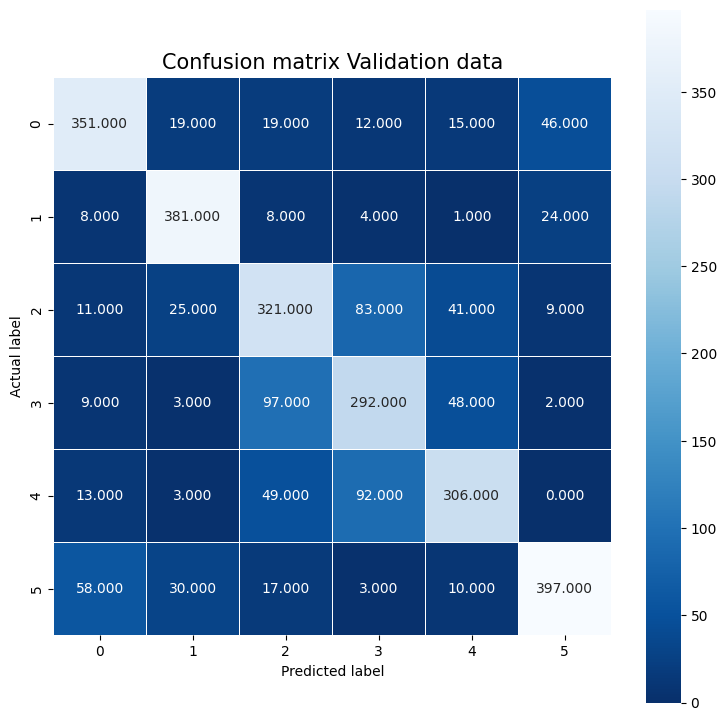

In [ ]:
# Train the SVM model
model = SVM(X_train, Y_train, X_val, Y_val)

### **Test Accuracy** ###

Accuracy Test set: 70.6


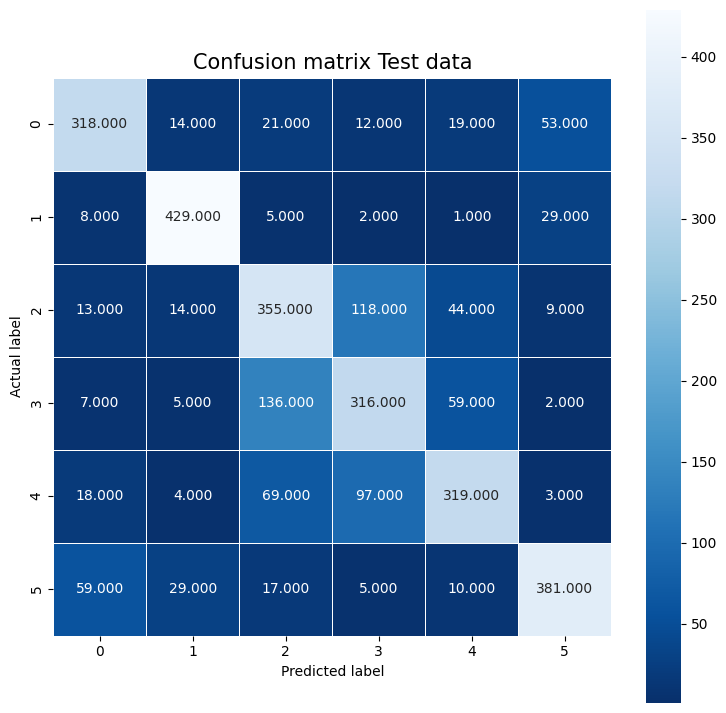

In [ ]:
print("Accuracy Test set:", model.score(X_test, Y_test_numeric) * 100)

# Confusion matrix
get_confusion_matrix(model,X_test,Y_test_numeric,"Test")